# Variable Analysis - Statistics and Visualizations
Analyze variable differences between subpopulation and populations via statistics and visualizations.

In [1]:
import sys

import pandas as pd
import numpy as np
from sklearn.feature_selection import f_regression, f_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import pprint

DATA_DIR_NAME = '/Users/karenblakemore/Koverse/data/'

plt.rcParams.update({'figure.max_open_warning': 0})

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size ch

## Data Preparation

In [2]:
def data_preparation(pdf, drop_columns, coltype_map, null_value_map):
    null_count_map = {}
    
    pdf = pdf.drop(drop_columns, axis=1)

    for col in pdf:
        coltype = coltype_map[col]
        if coltype == 'continuous':
            pdf[col] = pdf[col].replace(null_value_map)
            pdf[col] = pd.to_numeric(pdf[col], downcast = 'integer')
            null_count_map[col] = pdf[col].isna().sum()
            
        elif coltype == 'discrete':
            pdf[col] = pdf[col].replace(null_value_map)
            pdf[col] = pd.to_numeric(pdf[col], downcast = 'integer')
            null_count_map[col] = pdf[col].isna().sum()
            
        elif coltype == 'categorical':
            null_count_map[col] = (pdf[col].values == '').sum()

        else:
            print('not continuous, discrete or categorical', col)
            
    return pdf, null_count_map

## Significance test for continuous variables

In [3]:
def continuous_significance(col, population, subpopulation, sig_pdf):
    u = population.mean()
    t, t_prob = stats.ttest_1samp(subpopulation, u)
    w, w_prob = stats.ranksums(subpopulation, population)
    sig_pdf = sig_pdf.append({'col': col, 't': t, 't_prob': t_prob, 'w': w, 'w_prob': w_prob}, ignore_index=True)
    return sig_pdf

## Descriptive statistics for continuous variables

In [4]:
def continuous_statistics(col, population, subpopulation, pop_nulls, subpop_nulls, coltype, sig_map):
    print('\033[1m' + col + '\033[0m')
    print('t-statistic', sig_map['t'], 'two-tailed p-value', sig_map['t_prob'])
    print('wilcoxon', sig_map['w'], 'two-sided p-value', sig_map['w_prob'])

    print('\033[1m' + '\nPopulation' + '\033[0m')
    print(population.describe().reset_index().to_string(header=None, index=None))
    print('median', population.median())
    print('null count', pop_nulls)
    if coltype == 'discrete':
        print('Normalized Value Counts')
        print(population.value_counts(normalize=True).sort_index().reset_index().to_string(header=None, index=None))
    
    print('\033[1m' + '\nSubpopulation' + '\033[0m')
    print(subpopulation.describe().reset_index().to_string(header=None, index=None))
    print('median', population.median())
    print('null count', subpop_nulls)
    if coltype == 'discrete':
        print('Normalized Value Counts')
        print(subpopulation.value_counts(normalize=True).sort_index().reset_index().to_string(header=None, index=None))

## Visualizations for continuous variables

In [15]:
def continuous_visualizations(col, population, subpopulation):
    try:
        sns.distplot(population, label='population', hist=False)
        sns.distplot(subpopulation, label='subpopulation', hist=False)
        plt.legend()
        plt.show()
    except:
        print("continuous_visualization failed", sys.exc_info()[0])
    print('\n')

## Significance test for categorical variables

In [6]:
def categorical_significance(col, population, subpopulation, sig_pdf):
    pop_value_counts = population.value_counts()
    subpop_value_counts = subpopulation.value_counts()
    subpop_value_counts = subpop_value_counts.reindex(pop_value_counts.index, fill_value=0)
   
    chisq, chisq_prob = stats.chisquare(subpop_value_counts, f_exp = pop_value_counts)
    sig_pdf = sig_pdf.append({'col': col, 'chisq': chisq, 'chisq_prob': chisq_prob}, ignore_index=True)
    return sig_pdf

## Descriptive statistics for categorical variables

In [7]:
def categorical_statistics(col, population, subpopulation, pop_nulls, subpop_nulls, sig_map):   
    print('\033[1m' + col + '\033[0m')
    print('chisq test statistic', sig_map['chisq'], 'p-value', sig_map['chisq_prob'])
    print('\033[1m' + '\nPopulation' + '\033[0m')
    print(population.describe().reset_index().to_string(header=None, index=None))
    print('null count', pop_nulls)
    print('Normalized Value Counts')
    print(population.value_counts(normalize=True).sort_index().reset_index().to_string(header=None, index=None))
    
    print('\033[1m' + '\nSubpopulation' + '\033[0m')
    print(subpopulation.describe().reset_index().to_string(header=None, index=None))
    print('null count', subpop_nulls)
    print('Normalized Value Counts')
    print(subpopulation.value_counts(normalize=True).sort_index().reset_index().to_string(header=None, index=None))

## Visualizations for categorical variables

In [8]:
def categorical_visualizations(col, population, subpopulation):
    pop_freqs = population.value_counts(normalize=True)
    subpop_freqs = subpopulation.value_counts(normalize=True)
    
    freqs_pdf = pd.DataFrame(dict(population = pop_freqs, subpopulation = subpop_freqs))
    freqs_pdf.index = freqs_pdf.index.set_names([col])
    freqs_pdf = freqs_pdf.reset_index()
    freqs_pdf = freqs_pdf.fillna(0)
    
    freqs_pdf = freqs_pdf.melt(id_vars=[col], value_vars=['population','subpopulation'], 
                        var_name='Group', value_name='Relative Frequency')

    sns.barplot(x='Relative Frequency', y=col, hue='Group', data=freqs_pdf)

    plt.show()
    print('\n')

## Variable Analysis
Sort variables in order of significant difference between population and subpopulation.
Then calculate descriptive statistics and create visualizations.

In [9]:
SIG_CONTINUOUS_COLUMNS = ['col', 't', 't_prob', 'w', 'w_prob']
SIG_CATEGORICAL_COLUMNS = ['col', 'chisq', 'chisq_prob']

def analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map):
    prepped_pdf, pop_null_count_map = data_preparation(pdf, drop_columns, coltype_map, value_map)
    prepped_subpop_pdf, subpop_null_count_map = data_preparation(subpop_pdf, drop_columns, coltype_map, value_map)
    
    ## Continuous Variables ##
    sig_pdf = pd.DataFrame(columns = SIG_CONTINUOUS_COLUMNS)
    continuous_cols = [col for col, col_type in coltype_map.items() if col_type in ('continuous', 'discrete')]
    for col in continuous_cols:
        pop = prepped_pdf[col].dropna()
        subpop = prepped_subpop_pdf[col].dropna()
        sig_pdf = continuous_significance(col, pop, subpop, sig_pdf)
        
    sig_pdf['significance'] = sig_pdf['t'].abs() * (1 - sig_pdf['t_prob'])
    sig_pdf = sig_pdf.sort_values(by='significance', ascending=False)
    
    for col in sig_pdf['col']:
        pop = prepped_pdf[col].dropna()
        subpop = prepped_subpop_pdf[col].dropna()
        continuous_statistics(col, pop, subpop, pop_null_count_map[col], subpop_null_count_map[col], 
                                  coltype_map[col], sig_pdf[sig_pdf['col'] == col].to_dict('records')[0])
        continuous_visualizations(col, pop, subpop)

    ## Categorical Variables ##
    sig_pdf = pd.DataFrame(columns = SIG_CATEGORICAL_COLUMNS)
    categorical_cols = [col for col, col_type in coltype_map.items() if col_type in ('categorical')]
    for col in categorical_cols:
        pop = prepped_pdf[col].dropna()
        subpop = prepped_subpop_pdf[col].dropna()
        sig_pdf = categorical_significance(col, pop, subpop, sig_pdf)
        
    sig_pdf['significance'] = sig_pdf['chisq'].abs() * (1 - sig_pdf['chisq_prob'])
    sig_pdf = sig_pdf.sort_values(by='significance', ascending=False)
    for col in sig_pdf['col']:
        pop = prepped_pdf[col].dropna()
        subpop = prepped_subpop_pdf[col].dropna()
        categorical_statistics(col, pop, subpop, pop_null_count_map[col], subpop_null_count_map[col], 
                                  sig_pdf[sig_pdf['col'] == col].to_dict('records')[0])
        categorical_visualizations(col, pop, subpop)

## Experiment - NY Subpopulation of Hospital Readmission Data Set

In [ ]:
DATA_SET_NAME = 'hospital_readmissions'

value_map = {'Below the national average': 1,
             'Same as the national average': 2, 
             'Above the national average': 3,
             'Not Available': np.nan,
             'Too Few to Report': np.nan,
             'Results are not available for this reporting period': np.nan
            }

drop_columns = ['Address',
                'City', 
                'County Name', 
                'Effectiveness of care national comparison footnote',
                'Efficient use of medical imaging national comparison footnote',
                'Emergency Services',
                'End Date',
                'Footnote',
                'Hospital Name',
                'Hospital overall rating footnote',
                'Hospital Type',
                'Measure Name',
                'Meets criteria for meaningful use of EHRs',
                'Mortality national comparison footnote',
                'Patient experience national comparison footnote',
                'Phone Number',
                'Provider ID',
                'Provider Number',
                'Readmission national comparison footnote',
                'Safety of care national comparison footnote',
                'Start Date',
                'State',
                'Timeliness of care national comparison footnote',
                'ZIP Code',
                'ï»¿Hospital Name'
               ]

coltype_map = {'Excess Readmission Ratio': 'continuous',
               'Expected Readmission Rate': 'continuous',
               'Predicted Readmission Rate': 'continuous',
               'Number of Discharges': 'continuous',               
               'Number of Readmissions': 'continuous',
               'Effectiveness of care national comparison': 'discrete',
               'Efficient use of medical imaging national comparison': 'discrete',
               'Hospital overall rating': 'discrete',
               'Mortality national comparison': 'discrete',
               'Patient experience national comparison': 'discrete',
               'Readmission national comparison': 'discrete',
               'Safety of care national comparison': 'discrete',
               'Timeliness of care national comparison': 'discrete',  
               'Hospital Ownership': 'categorical'
              }


pdf = pd.read_csv(DATA_DIR_NAME + DATA_SET_NAME + '.csv', encoding='latin-1')
subpop_pdf = pdf[pdf['State'] == 'NY']
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

## Experiment - Survived subpopulation of Titanic Data Set

Pclass
t-statistic -7.676227465092112 two-tailed p-value 1.7434892651540985e-13
wilcoxon -6.08495901985807 two-sided p-value 1.1652110989906615e-09

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  342.000000
 mean    1.950292
  std    0.863321
  min    1.000000
  25%    1.000000
  50%    2.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.397661
2  0.254386
3  0.347953


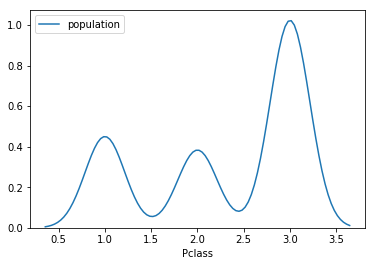



Fare
t-statistic 4.496115165879792 two-tailed p-value 9.497580745229645e-06
wilcoxon 6.444027427341805 two-sided p-value 1.1634404570501734e-10

Population
count  891.000000
 mean   32.204208
  std   49.693429
  min    0.000000
  25%    7.910400
  50%   14.454200
  75%   31.000000
  max  512.329200
median 14.4542
null count 0

Subpopulation
count  342.000000
 mean   48.395408
  std   66.596998
  min    0.000000
  25%   12.475000
  50%   26.000000
  75%   57.000000
  max  512.329200
median 14.4542
null count 0


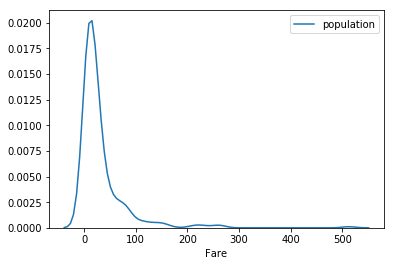



Parch
t-statistic 1.996639121148842 two-tailed p-value 0.046658989398454906
wilcoxon 2.05329963961097 two-sided p-value 0.04004352580652834

Population
count  891.000000
 mean    0.381594
  std    0.806057
  min    0.000000
  25%    0.000000
  50%    0.000000
  75%    0.000000
  max    6.000000
median 0.0
null count 0

Subpopulation
count  342.000000
 mean    0.464912
  std    0.771712
  min    0.000000
  25%    0.000000
  50%    0.000000
  75%    1.000000
  max    5.000000
median 0.0
null count 0


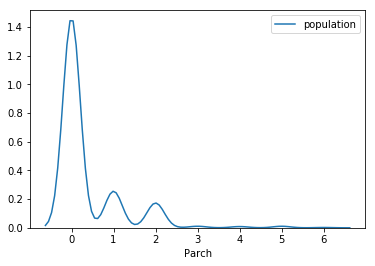



Age
t-statistic -1.5438553337279277 two-tailed p-value 0.12371765152907183
wilcoxon -0.9120411797975395 two-sided p-value 0.3617470402592682

Population
count  714.000000
 mean   29.699118
  std   14.526497
  min    0.420000
  25%   20.125000
  50%   28.000000
  75%   38.000000
  max   80.000000
median 28.0
null count 177

Subpopulation
count  290.000000
 mean   28.343690
  std   14.950952
  min    0.420000
  25%   19.000000
  50%   28.000000
  75%   36.000000
  max   80.000000
median 28.0
null count 52


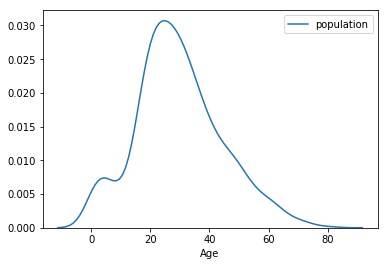



SibSp
t-statistic -1.2871034049081107 two-tailed p-value 0.19893122088978607
wilcoxon 1.4477066538548198 two-sided p-value 0.14769910826409738

Population
count  891.000000
 mean    0.523008
  std    1.102743
  min    0.000000
  25%    0.000000
  50%    0.000000
  75%    1.000000
  max    8.000000
median 0.0
null count 0

Subpopulation
count  342.000000
 mean    0.473684
  std    0.708688
  min    0.000000
  25%    0.000000
  50%    0.000000
  75%    1.000000
  max    4.000000
median 0.0
null count 0


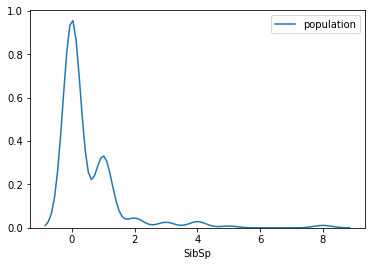



Sex
chisq test statistic 400.48589232688295 p-value 4.316802307681025e-89

Population
count   891
unique     2
   top  male
  freq   577
null count 0
Normalized Value Counts
female  0.352413
  male  0.647587

Subpopulation
count     342
unique       2
   top  female
  freq     233
null count 0
Normalized Value Counts
female  0.681287
  male  0.318713


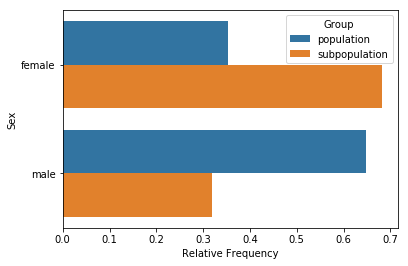



Embarked
chisq test statistic 345.2900197628458 p-value 1.0500860289332201e-75

Population
count  889
unique    3
   top    S
  freq  644
null count 0
Normalized Value Counts
C  0.188976
Q  0.086614
S  0.724409

Subpopulation
count  340
unique    3
   top    S
  freq  217
null count 0
Normalized Value Counts
C  0.273529
Q  0.088235
S  0.638235


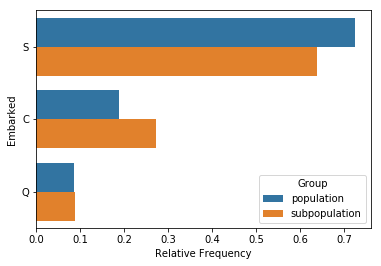

In [14]:
DATA_SET_NAME = 'titanic'

value_map = {}

drop_columns = ['Cabin',
                'Name',
                'PassengerId',
                'Ticket',
                'Survived'
               ]

coltype_map = {'Age': 'continuous',
               'Embarked': 'categorical',
               'Fare': 'continuous',
               'Parch': 'continuous',
               'Pclass': 'discrete',
               'Sex': 'categorical',
               'SibSp': 'continuous',
              }

pdf = pd.read_csv(DATA_DIR_NAME + DATA_SET_NAME + '.csv', encoding='latin-1')
subpop_pdf = pdf[pdf['Survived'] == 1]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

Pclass
t-statistic -7.676227465092112 two-tailed p-value 1.7434892651540985e-13
wilcoxon -6.08495901985807 two-sided p-value 1.1652110989906615e-09

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  342.000000
 mean    1.950292
  std    0.863321
  min    1.000000
  25%    1.000000
  50%    2.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.397661
2  0.254386
3  0.347953


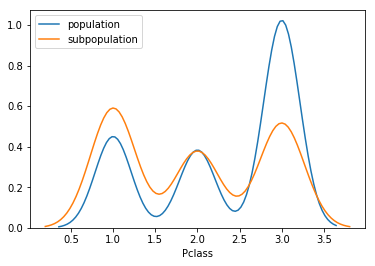



Pclass
t-statistic 7.108599870135736 two-tailed p-value 3.671359588740356e-12
wilcoxon 4.44436918744584 two-sided p-value 8.81501223613923e-06

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  549.000000
 mean    2.531876
  std    0.735805
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.145719
2  0.176685
3  0.677596


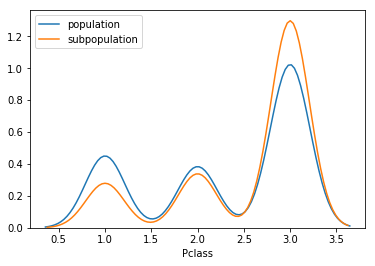



Pclass
t-statistic -5.790001075380106 two-tailed p-value 3.406188815522803e-08
wilcoxon -4.902004843572933 two-sided p-value 9.486349686728258e-07

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  168.000000
 mean    1.886905
  std    0.944100
  min    1.000000
  25%    1.000000
  50%    1.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.505952
2  0.101190
3  0.392857


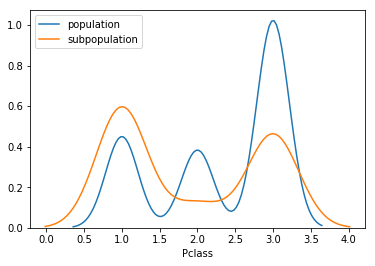



Pclass
t-statistic 14.268297422420599 two-tailed p-value 3.39128435180476e-23
wilcoxon 5.655931495756642 two-sided p-value 1.5500328640000968e-08

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  77.000000
 mean   2.909091
  std   0.369274
  min   1.000000
  25%   3.000000
  50%   3.000000
  75%   3.000000
  max   3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.025974
2  0.038961
3  0.935065


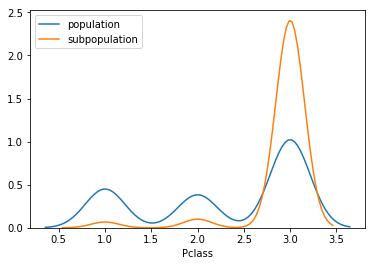



Pclass
t-statistic 1.3594996277282987 two-tailed p-value 0.1744648769077432
wilcoxon 0.6053009272452888 two-sided p-value 0.5449790654345135

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  644.000000
 mean    2.350932
  std    0.789402
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.197205
2  0.254658
3  0.548137


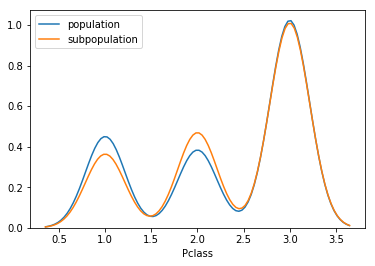



Pclass
t-statistic 2.4005476100806717 two-tailed p-value 0.016686770993254038
wilcoxon 1.685958022498206 two-sided p-value 0.09180388492004246

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  577.000000
 mean    2.389948
  std    0.813580
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.211438
2  0.187175
3  0.601386


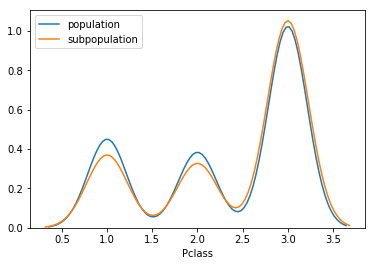



Pclass
t-statistic -3.0882036113859006 two-tailed p-value 0.0021940926717379677
wilcoxon -2.5223600759614615 two-sided p-value 0.011657031618143942

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  314.000000
 mean    2.159236
  std    0.857290
  min    1.000000
  25%    1.000000
  50%    2.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.299363
2  0.242038
3  0.458599


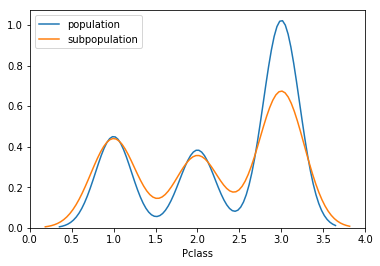



Pclass
t-statistic 4.32391734720715 two-tailed p-value 1.9288989573044505e-05
wilcoxon 2.64293488066604 two-sided p-value 0.008219084108468408

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  409.000000
 mean    2.466993
  std    0.740635
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.149144
2  0.234719
3  0.616137


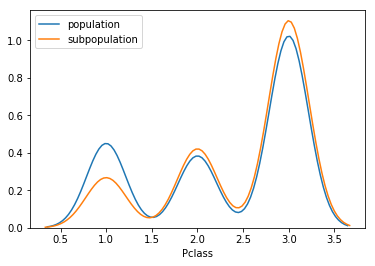



Pclass
t-statistic -7.705524535124887 two-tailed p-value 1.8592280656424834e-13
wilcoxon -6.179784513773409 two-sided p-value 6.41891553260906e-10

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  305.000000
 mean    1.927869
  std    0.863006
  min    1.000000
  25%    1.000000
  50%    2.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.409836
2  0.252459
3  0.337705


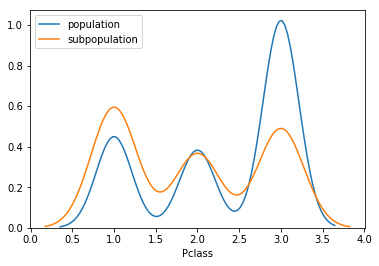



Pclass
t-statistic 0.4012192887757528 two-tailed p-value 0.6883852852623109
wilcoxon 0.3107344356788278 two-sided p-value 0.7560025163780877

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  678.000000
 mean    2.321534
  std    0.836665
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.240413
2  0.197640
3  0.561947


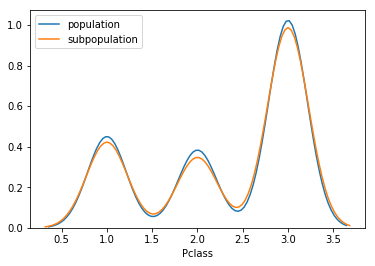



Pclass
t-statistic -1.0698626378696787 two-tailed p-value 0.28593310430739405
wilcoxon -0.9641331760437531 two-sided p-value 0.3349791615829708

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  207.000000
 mean    2.246377
  std    0.837341
  min    1.000000
  25%    1.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.256039
2  0.241546
3  0.502415


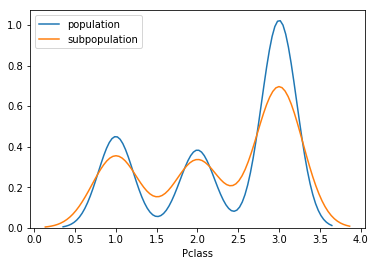



Pclass
t-statistic inf two-tailed p-value 0.0
wilcoxon 1.8972266807925058 two-sided p-value 0.05779802692357041

Population
count  891.000000
 mean    2.308642
  std    0.836071
  min    1.000000
  25%    2.000000
  50%    3.000000
  75%    3.000000
  max    3.000000
median 3.0
null count 0
Normalized Value Counts
1  0.242424
2  0.206510
3  0.551066

Subpopulation
count  6.0
 mean  3.0
  std  0.0
  min  3.0
  25%  3.0
  50%  3.0
  75%  3.0
  max  3.0
median 3.0
null count 0
Normalized Value Counts
3  1.0
continuous_visualization failed <class 'numpy.linalg.linalg.LinAlgError'>




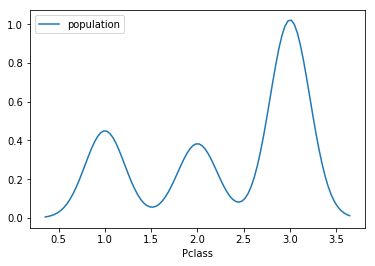

In [19]:
DATA_SET_NAME = 'titanic'

value_map = {}

drop_columns = ['Age',
                'Cabin',
                'Embarked',
                'Fare',
                'Name',
                'Parch',
                'PassengerId',
                'Sex',
                'SibSp',
                'Survived',
                'Ticket'               
               ]

coltype_map = {
               'Pclass': 'discrete'
              }

pdf = pd.read_csv(DATA_DIR_NAME + DATA_SET_NAME + '.csv', encoding='latin-1')

subpop_pdf = pdf[pdf['Survived'] == 1]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Survived'] == 0]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Embarked'] == "C"]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Embarked'] == "Q"]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Embarked'] == "S"]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Sex'] == "male"]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Sex'] == "female"]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Age'] <= 30]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Age'] > 30]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Parch'] == 0]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[(pdf['Parch'] >= 1) & (pdf['Parch'] <= 4)]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

subpop_pdf = pdf[pdf['Parch'] > 4]
analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)

## Experiment - Transaction Cluster Subpopulations of Titanic Data Set

In [ ]:
DATA_SET_NAME = 'titanic'
CLUSTER_COUNT = 10

value_map = {}

drop_columns = ['Cabin',
                'Name',
                'PassengerId',
                'Ticket'
               ]

coltype_map = {'Age': 'continuous',
               'Embarked': 'categorical',
               'Fare': 'continuous',
               'Parch': 'continuous',
               'Pclass': 'discrete',
               'Sex': 'categorical',
               'SibSp': 'continuous',
               'Survived': 'discrete'
              }

pdf = pd.read_csv(DATA_DIR_NAME + DATA_SET_NAME + '.csv', encoding='latin-1')
pdf_clusters = pd.read_csv(DATA_DIR_NAME + DATA_SET_NAME + '_clusters.csv', encoding='latin-1')
for i in range(1,CLUSTER_COUNT+1):
    print('\033[1m' + 'Analyzing Cluster ' + str(i) + '\033[0m')
    subpop_pdf = pdf_clusters[pdf_clusters['__CLUSTER__'] == i].drop(['__CLUSTER__'], axis=1)
    analyze_variables(pdf, subpop_pdf, drop_columns, coltype_map, value_map)